In [1]:
# this script, together with the lib process_mouse_trials_lib
# is used to process the raw excel files that have the tracking
# of the mouse in the arena looking for the hidden food
#
# the experiments were originally performed by Kelly Xu from Len Maler lab
#
# the original excel files are not going to be included in this repository
#
# instead, we provide only the processed files (in .mat format)
# that contain all the relevant information for the trajectories
# extracted from the excel files...
#
# this scripts tests the parameters extracted from the arena

import os
import copy
import numpy
import modules.io as io
import modules.plot_func as pltt
import modules.traj_analysis as tran
import modules.edge_detector as edged
import modules.helper_func_class as misc
import modules.traj_to_step_matrix as tstep
import modules.process_mouse_trials_lib as plib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors
import PIL.Image




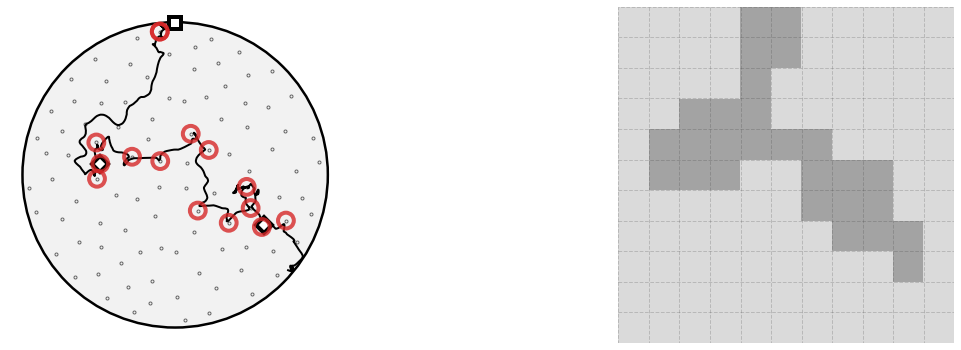

In [7]:
config_param           = dict(mouse_part           = ['nose']                           ,
                                L                    = [11]                               ,
                                prob_calc            = [misc.ProbabilityType.independent] ,
                                start_from_zero      = [False]                            ,
                                n_stages             = []                                 ,
                                stop_at_food         = [False]                             ,
                                use_latest_target    = [True]                             )

inp_idx = 3


filename_expr          = 'mpos_*Probe2_*'
keep_between_targets   = False
stop_at_food           = config_param['stop_at_food']
hole_horizon           = 10.0 # cm
time_delay_after_food  = 20.0 # sec
mouse_traj_dir         = r'./experiments/two_target_no_cues/mouse_*'
input_tracks           = io.load_trial_file(mouse_traj_dir,file_name_expr=filename_expr,align_to_top=True,fix_nan=True,sort_by_trial=True,return_group_by_keys=False,remove_after_food=False)
if keep_between_targets:
    input_tracks       = tran.keep_path_between_targets(input_tracks,return_t_in_targets=False,hole_horizon=hole_horizon,time_delay_after_food=time_delay_after_food,copy_tracks=True)
elif stop_at_food:
    input_tracks       = tran.remove_path_after_food(input_tracks,force_main_target=False,return_t_to_food=False,hole_horizon=hole_horizon,time_delay_after_food=time_delay_after_food,copy_tracks=True)
use_extra_trials       = [True]
align_method           = ['entrance'] # 'entrance' or 'target'

n_trial_max              = numpy.unique([ plib.trial_to_number(tr.trial) for tr in input_tracks ]).size #n_trials_to_use if n_trials_to_use else max([ int(plib.trial_to_number(tr.trial)) for tr in input_tracks ])
config_param['n_stages'] = [n_trial_max]
config = tstep.get_step_prob_input_param_config_list(mouse_part        = config_param['mouse_part']       ,
                                                        n_stages          = config_param['n_stages']         ,
                                                        L_lattice         = config_param['L']                ,
                                                        prob_calc         = config_param['prob_calc']        ,
                                                        start_from_zero   = config_param['start_from_zero']  ,
                                                        use_extra_trials  = use_extra_trials                 ,
                                                        stop_at_food      = config_param['stop_at_food']     ,
                                                        align_method      = align_method                     ,
                                                        use_latest_target = config_param['use_latest_target'])

param_struct   = tstep.get_calc_step_probability_param_struct(**config[0])
step_prob_data = tstep.calc_step_probability(param_struct=param_struct,tracks=input_tracks,return_as_file_struct=True)


ignore_entrance_positions   = False
normalize_by                = 'max'
hole_horizon_hole_check     = 3.0 #cm
threshold_method            = 'ampv'
velocity_amplitude_fraction = 0.2
use_velocity_minima         = True
velocity_min_prominence     = 5.0 # cm/s
join_vmin_vthresh_output    = True
k_slow,t_slow,r_slow,v_th   = tran.find_slowing_down_close_to_hole(input_tracks[inp_idx],hole_horizon_hole_check,threshold_method=threshold_method,gamma=velocity_amplitude_fraction,
                                                                                                 return_pos_from='hole',ignore_entrance_positions=ignore_entrance_positions,
                                                                                                 use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence,join_vmin_vthresh_output=join_vmin_vthresh_output)



fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(16,8))

#for k,(track,P) in enumerate(zip(input_tracks,step_prob_data.P_specific[0])):
track,P = input_tracks[inp_idx],step_prob_data.P_specific[0][inp_idx]
G = numpy.zeros((param_struct.L_lattice,param_struct.L_lattice))
G[numpy.unravel_index(numpy.unique(P.nonzero()[0]),shape=(param_struct.L_lattice,param_struct.L_lattice),order='F')] = 1

aax = ax[0]
pltt.plot_arena_sketch(track,showAllEntrances=False,arenaPicture=False,showHoles=True,ax=aax,
                       bgCircleArgs = dict(linewidth=2.5,facecolor=0.95*numpy.ones(3),fill=True),
                       holesArgs    = dict(color=0.4*numpy.ones(3)))
pltt.plot_mouse_trajectory(aax,track,mouse_part='nose',show_reverse_target=False,show_alt_target=True,
                           startArgs     = dict(marker='s',markeredgewidth=4,color='k',markersize=12,fillstyle='full',markerfacecolor='w'),
                           targetArgs    = dict(marker='D',markeredgewidth=4,color='k',markersize=12,fillstyle='full',markerfacecolor='w'),
                           targetAltArgs = dict(marker='D',markeredgewidth=4,color='k',markersize=12,fillstyle='full',markerfacecolor='w'),
                           color='k',linewidth=2,alpha=1)
                           #line_gradient_variable='velocity',color=plt.get_cmap('turbo'),linewidth=3,alpha=0.4,)

t_seq = track.time[k_slow]/track.time[-1]
#path_c = pltt.plot_trajectory_points(r_slow,ax=aax,use_scatter=True,s=200,marker='o',facecolors='none',edgecolors=plt.get_cmap('turbo')(t_seq),zorder=10000,alpha=0.8,linewidths=3)
path_c = pltt.plot_trajectory_points(r_slow,ax=aax,use_scatter=True,s=250,marker='o',facecolors='none',edgecolors='tab:red',zorder=10000,alpha=0.8,linewidths=4)


aax.autoscale()
aax.set_aspect('equal','box')

aax = ax[1]
#cmap_grid = plt.get_cmap('binary')
cmap_grid = matplotlib.colors.LinearSegmentedColormap.from_list('grid_map',[ (0.0,0.82*numpy.ones(3)),(1.0,0.55*numpy.ones(3)) ])
pltt.plot_arena_grid(aax,G,line_color=tuple(0.2*numpy.ones(3))+(0.2,),show_grid_lines=True,grid_alpha=0.8,cmap_grid=cmap_grid)

for a in fig.get_children():
    if '_label' in a.__dict__:
        if a._label == 'color_traj':
            a.remove()

pltt.tight_arena_panels(ax,set_axis_off=True,adjust_title_position=True,dy0=-0.2)

plt.tight_layout()
plt.savefig('figs/trajectory_example_grid.png',dpi=300)

plt.show()


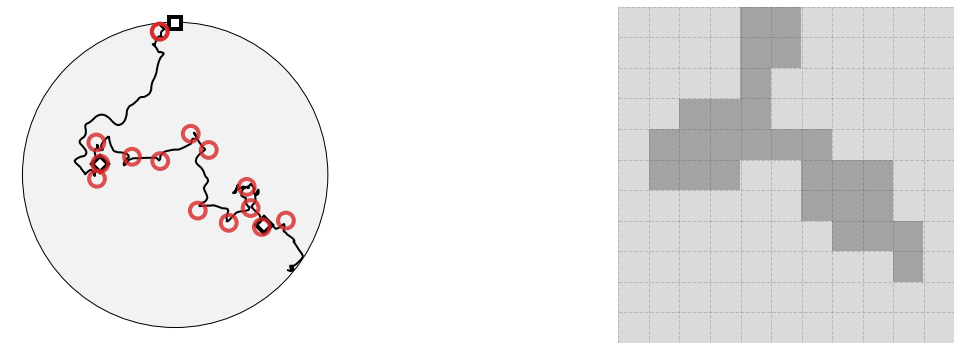

In [6]:
config_param           = dict(mouse_part           = ['nose']                           ,
                                L                    = [11]                               ,
                                prob_calc            = [misc.ProbabilityType.independent] ,
                                start_from_zero      = [False]                            ,
                                n_stages             = []                                 ,
                                stop_at_food         = [False]                             ,
                                use_latest_target    = [True]                             )

inp_idx = 3


filename_expr          = 'mpos_*Probe2_*'
keep_between_targets   = False
stop_at_food           = config_param['stop_at_food']
hole_horizon           = 10.0 # cm
time_delay_after_food  = 20.0 # sec
mouse_traj_dir         = r'./experiments/two_target_no_cues/mouse_*'
input_tracks           = io.load_trial_file(mouse_traj_dir,file_name_expr=filename_expr,align_to_top=True,fix_nan=True,sort_by_trial=True,return_group_by_keys=False,remove_after_food=False)
if keep_between_targets:
    input_tracks       = tran.keep_path_between_targets(input_tracks,return_t_in_targets=False,hole_horizon=hole_horizon,time_delay_after_food=time_delay_after_food,copy_tracks=True)
elif stop_at_food:
    input_tracks       = tran.remove_path_after_food(input_tracks,force_main_target=False,return_t_to_food=False,hole_horizon=hole_horizon,time_delay_after_food=time_delay_after_food,copy_tracks=True)
use_extra_trials       = [True]
align_method           = ['entrance'] # 'entrance' or 'target'

n_trial_max              = numpy.unique([ plib.trial_to_number(tr.trial) for tr in input_tracks ]).size #n_trials_to_use if n_trials_to_use else max([ int(plib.trial_to_number(tr.trial)) for tr in input_tracks ])
config_param['n_stages'] = [n_trial_max]
config = tstep.get_step_prob_input_param_config_list(mouse_part        = config_param['mouse_part']       ,
                                                        n_stages          = config_param['n_stages']         ,
                                                        L_lattice         = config_param['L']                ,
                                                        prob_calc         = config_param['prob_calc']        ,
                                                        start_from_zero   = config_param['start_from_zero']  ,
                                                        use_extra_trials  = use_extra_trials                 ,
                                                        stop_at_food      = config_param['stop_at_food']     ,
                                                        align_method      = align_method                     ,
                                                        use_latest_target = config_param['use_latest_target'])

param_struct   = tstep.get_calc_step_probability_param_struct(**config[0])
step_prob_data = tstep.calc_step_probability(param_struct=param_struct,tracks=input_tracks,return_as_file_struct=True)


ignore_entrance_positions   = False
normalize_by                = 'max'
hole_horizon_hole_check     = 3.0 #cm
threshold_method            = 'ampv'
velocity_amplitude_fraction = 0.2
use_velocity_minima         = True
velocity_min_prominence     = 5.0 # cm/s
join_vmin_vthresh_output    = True
k_slow,t_slow,r_slow,v_th   = tran.find_slowing_down_close_to_hole(input_tracks[inp_idx],hole_horizon_hole_check,threshold_method=threshold_method,gamma=velocity_amplitude_fraction,
                                                                                                 return_pos_from='hole',ignore_entrance_positions=ignore_entrance_positions,
                                                                                                 use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence,join_vmin_vthresh_output=join_vmin_vthresh_output)



fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(16,8))

#for k,(track,P) in enumerate(zip(input_tracks,step_prob_data.P_specific[0])):
track,P = input_tracks[inp_idx],step_prob_data.P_specific[0][inp_idx]
G = numpy.zeros((param_struct.L_lattice,param_struct.L_lattice))
G[numpy.unravel_index(numpy.unique(P.nonzero()[0]),shape=(param_struct.L_lattice,param_struct.L_lattice),order='F')] = 1

aax = ax[0]
pltt.plot_arena_sketch(track,showAllEntrances=False,arenaPicture=False,showHoles=False,ax=aax,
                       bgCircleArgs = dict(linewidth=1.0,facecolor=0.95*numpy.ones(3),fill=True),
                       holesArgs    = dict(color=0.4*numpy.ones(3)))
pltt.plot_mouse_trajectory(aax,track,mouse_part='nose',show_reverse_target=False,show_alt_target=True,
                           startArgs     = dict(marker='s',markeredgewidth=4,color='k',markersize=12,fillstyle='full',markerfacecolor='w'),
                           targetArgs    = dict(marker='D',markeredgewidth=4,color='k',markersize=12,fillstyle='full',markerfacecolor='w'),
                           targetAltArgs = dict(marker='D',markeredgewidth=4,color='k',markersize=12,fillstyle='full',markerfacecolor='w'),
                           color='k',linewidth=2,alpha=1)
                           #line_gradient_variable='velocity',color=plt.get_cmap('turbo'),linewidth=3,alpha=0.4,)

t_seq = track.time[k_slow]/track.time[-1]
#path_c = pltt.plot_trajectory_points(r_slow,ax=aax,use_scatter=True,s=200,marker='o',facecolors='none',edgecolors=plt.get_cmap('turbo')(t_seq),zorder=10000,alpha=0.8,linewidths=3)
path_c = pltt.plot_trajectory_points(r_slow,ax=aax,use_scatter=True,s=250,marker='o',facecolors='none',edgecolors='tab:red',zorder=10000,alpha=0.8,linewidths=4)


aax.autoscale()
aax.set_aspect('equal','box')

aax = ax[1]
#cmap_grid = plt.get_cmap('binary')
cmap_grid = matplotlib.colors.LinearSegmentedColormap.from_list('grid_map',[ (0.0,0.82*numpy.ones(3)),(1.0,0.55*numpy.ones(3)) ])
pltt.plot_arena_grid(aax,G,line_color=tuple(0.2*numpy.ones(3))+(0.2,),show_grid_lines=True,grid_alpha=0.8,cmap_grid=cmap_grid)

for a in fig.get_children():
    if '_label' in a.__dict__:
        if a._label == 'color_traj':
            a.remove()

pltt.tight_arena_panels(ax,set_axis_off=True,adjust_title_position=True,dy0=-0.2)

plt.tight_layout()
plt.savefig('figs/trajectory_example_grid_no_holes.png',dpi=300)

plt.show()
